# Vorhersage von Taxibestellungen

Die Taxiflotte hat historische Daten zu Taxibestellungen an Flughäfen gesammelt. Um während der Spitzenzeiten mehr Fahrer anzuziehen, müssen wir die Anzahl der Taxibestellungen für die nächste Stunde vorhersagen. Für eine solche Vorhersage muss ein Modell erstellt werden.

## Datenaufbereitung

In [246]:
# Wir importieren die notwendigen Bibliotheken.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import TimeSeriesSplit

In [247]:
# Wir laden Tabellen mit Daten.
df = pd.read_csv('E:/datasets/taxi.csv', index_col=[0], parse_dates=[0])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


(26496, 1)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


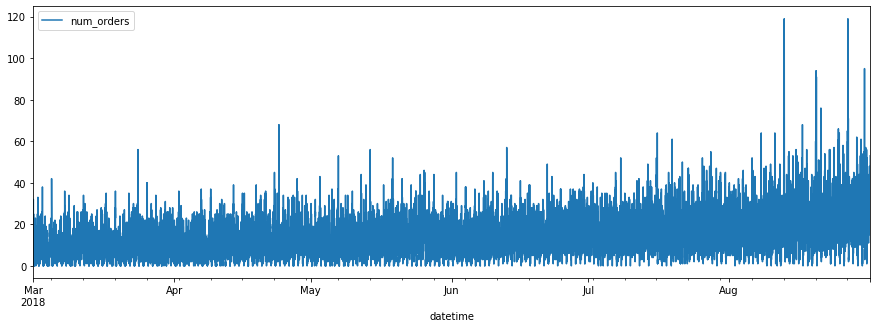

In [248]:
# Wir werden die erhaltenen Daten studieren.
df.info()
display(df.shape)
display(df)
df.plot(figsize=(15, 5))

**Schlussfolgerungen**

Wir haben Daten für sechs Monate: vom 1. März bis 31. August 2018. Die Tabelle zeigt die Anzahl der Taxibestellungen alle 10 Minuten.

Es gibt insgesamt 26496 Zeilen in der Tabelle.

## Datenanalyse

In [249]:
# Wir werden das Resampling durchführen. 
# Das neue Intervall beträgt 1 Tag und enthält die Gesamtzahl der Taxiaufträge.
df_1 = df.resample('1D').sum()

Text(0.5, 1.0, 'Seasonality')

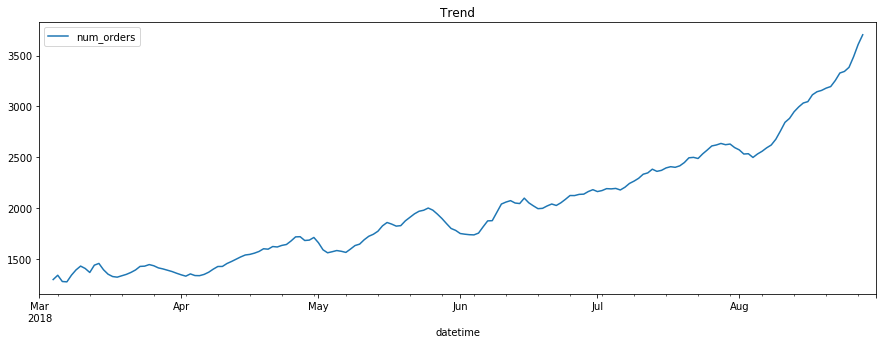

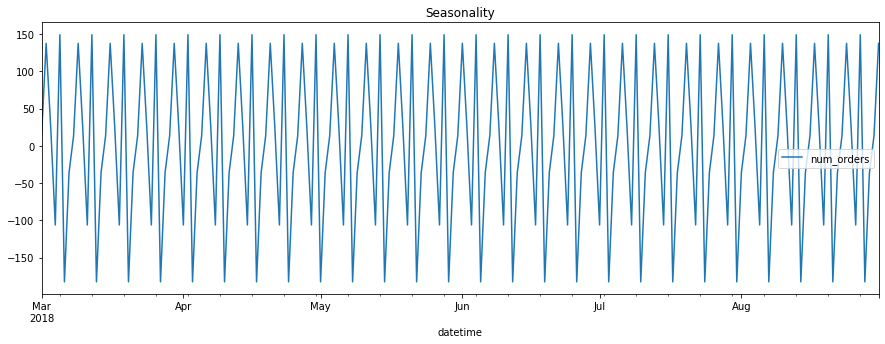

In [250]:
# Wir werden die Zeitreihe in einen Trend und eine saisonale Komponente aufteilen.
# Wir verwenden die Daten für den gesamten Zeitraum.
decomposed = seasonal_decompose(df_1)
decomposed.trend.plot(figsize=(15, 5))
plt.title('Trend')

decomposed = seasonal_decompose(df_1)
decomposed.seasonal.plot(figsize=(15, 5))
plt.title('Seasonality')

Text(0.5, 1.0, 'Seasonality')

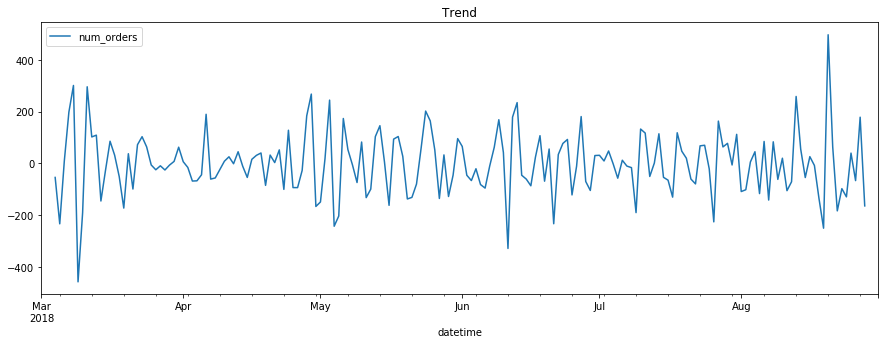

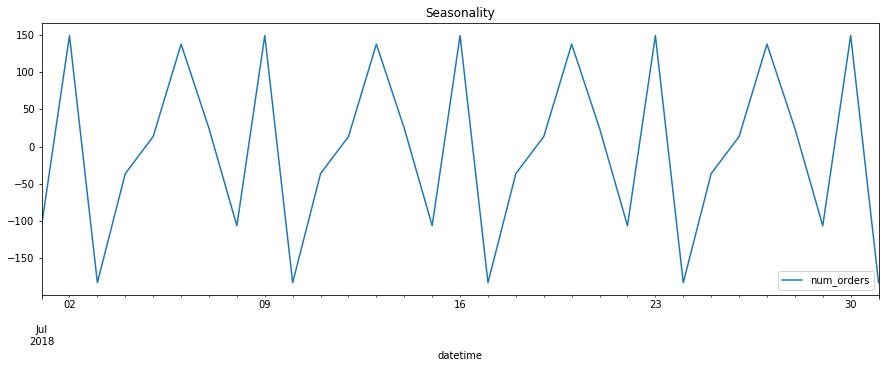

In [251]:
# Wir werden die Zeitreihe in einen Trend und eine saisonale Komponente aufteilen.
# Wir verwenden die verfügbaren Daten für Juli 2018.
decomposed = seasonal_decompose(df_1)
decomposed.resid.plot(figsize=(15, 5))
plt.title('Trend')

decomposed = seasonal_decompose(df_1)
decomposed.seasonal['2018-07-01':'2018-07-31'].plot(figsize=(15, 5))
plt.title('Seasonality')

**Schlussfolgerungen**

Nach der Analyse des Trendgraphen sehen wir, dass die Anzahl der Taxiaufträge ab April besonders im August deutlich ansteigt. Dies kann auf den Beginn der Ferienzeit und die zunehmende Bewegung der Bevölkerung zurückzuführen sein. Die Saisonalitätsgrafik zeigt uns die Abhängigkeit zwischen der Anzahl der Taxiaufträge und den Wochentagen. Wir werden die Saisonalität genauer analysieren, indem wir einen Zeitplan für Juli erstellen.

Wir sehen, dass die meisten Taxiaufträge am Freitag und Montag und am wenigsten am Dienstag stattfinden. Dies ist höchstwahrscheinlich auf die Bewegung von Passagieren am Wochenende zurückzuführen.

## Die optimalen Hyperparameter finden. Modelltraining.

In [252]:
# Wir werden das Resampling durchführen. 
# Das neue Intervall beträgt 1 Stunde und enthält die Gesamtzahl der Taxiaufträge.
df = df.resample('1H').sum()

# Wir fügen der Spalte 'rolling_mean' einen gleitenden Durchschnitt mit einer Fenstergröße von 10 hinzu.
df['rolling_mean'] = df.rolling(10).mean()

In [253]:
# Wir werden eine Feature-Creation-Funktion schreiben, um die Qualität der Modelle zu verbessern.
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [254]:
# Wir führen die Funktion make_features aus und sehen, was passiert.
make_features(df, 6, 10)
df

,num_orders,rolling_mean,hour,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,0,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,1,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,4,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,173.3,19,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0
2018-08-31 20:00:00,154,166.6,20,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0
2018-08-31 21:00:00,159,162.9,21,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0


In [255]:
# Wir werden Zeilen mit leeren Werten entfernen.
df = df.dropna()

# Wir werden die Zielmerkmale und -bedingungen hervorheben.
target = df['num_orders']
features = df.drop('num_orders', axis=1)

In [256]:
# Wir teilen die Daten in Stichproben auf.
features_train_1, features_valid, target_train_1, target_valid = train_test_split(
    features, target, test_size=0.20, shuffle=False)
features_train, features_test, target_train, target_test = train_test_split(
    features_train_1, target_train_1, test_size=0.125, shuffle=False)

In [257]:
# Wir werden verschiedene Modelle trainieren und die optimalen Hyperparameter auswählen.
model = LinearRegression() 
model.fit(features_train, target_train)
predictions = model.predict(features_valid)

print("RMSE:", mean_squared_error(target_valid, predictions)**0.5)

RMSE: 48.36788777666007


In [258]:
best_result = 100
best_depth = 0
for depth in range(15, 30):
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions) ** 0.5
    if result < best_result:
        best_result = result
        best_depth = depth
    
print('best_depth: ', best_depth, 'RMSE: ', best_result)

best_depth:  18 RMSE:  51.11653938814386


In [259]:
best_result = 100
best_est = 0
best_depth = 0
for est in range(90, 110, 10):
    for depth in range (14, 19):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train) 
        predictions = model.predict(features_valid) 
        result = mean_squared_error(target_valid, predictions)**0.5 
        if result < best_result:
            best_result = result
            best_est = est
            best_depth = depth
            
print('best_est: ', best_est, 'best_depth: ', best_depth, 'RMSE: ', best_result)

C:\anaconda\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
C:\anaconda\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
C:\anaconda\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
C:\anaconda\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
C:\anaconda\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: Dep

best_est:  90 best_depth:  16 RMSE:  49.416084487931265


C:\anaconda\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):


In [260]:
tscv = TimeSeriesSplit(n_splits=3)

def metric(target, predict): 
    return mean_squared_error(target, predict)**0.5

my_metric = make_scorer(metric, greater_is_better=False)

model = DecisionTreeRegressor()
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9]}
 
grid = GridSearchCV(model, parameters, cv = tscv, scoring = my_metric)
grid.fit(features_train, target_train)

display(grid.best_params_)
display(grid.best_score_)

{'max_depth': 7}

-29.193567556180547

**Schlussfolgerungen**

Wir haben Zeichen für das Modelltraining erstellt, die Daten in der Stichprobe aufgeschlüsselt und die optimalen Hyperparameter für die Modelle ausgewählt.

## Modelltest

Wir werden die Qualität der Modelle in einer Testprobe überprüfen.

In [261]:
model = LinearRegression() 
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print("RMSE LinearRegression: ", mean_squared_error(target_test, predictions)**0.5)

RMSE LinearRegression:  34.902262347337086


In [266]:
model = DecisionTreeRegressor(max_depth=7, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print("RMSE DecisionTreeRegressor: ", mean_squared_error(target_test, predictions)**0.5)

RMSE DecisionTreeRegressor:  31.43079582656077


In [267]:
model = RandomForestRegressor(random_state=12345, n_estimators=90, max_depth=16)
model.fit(features_train, target_train) 
predictions = model.predict(features_test) 
print("RMSE RandomForestRegressor: ", mean_squared_error(target_test, predictions)**0.5)

C:\anaconda\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):


RMSE RandomForestRegressor:  27.388378512511295


C:\anaconda\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):


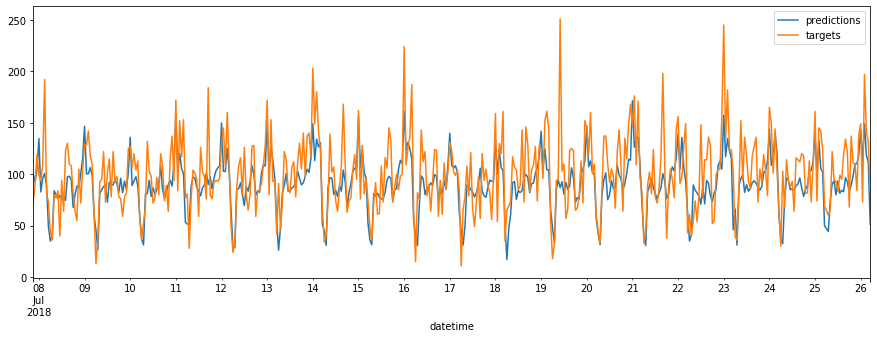

In [268]:
# Wir erstellen ein Diagramm anhand der Daten des Zielmerkmals in der Testprobe und 
# der Vorhersagen des RandomForestRegressor-Modells.
pd.DataFrame({'predictions': predictions, 'targets': target_test}, 
             index = target_test.index).resample('1H').sum().plot(figsize=(15, 5))

## Allgemeine Schlussfolgerung

Das RandomForestRegressor-Modell schnitt auf der Testprobe am besten ab. Wir haben unser RMSE-Ziel erreicht. Jetzt können wir die erforderliche Anzahl von Taxifahrern am Flughafen während der Hauptverkehrszeit vorhersagen.

Durch eine Voranalyse der Daten können wir die Tage der Spitzenlast in Abhängigkeit von Saison, Wochentag und Tageszeit ermitteln. Diese Arbeit wird die Gewinne von Organisationen erhöhen, die Taxidienste anbieten, weil. Bei höchster Nachfrage können Sie mehr Autos zum Flughafen schicken oder sie anderen Einrichtungen zuweisen, wenn die Nachfrage sinkt.